In [104]:
# Script to process data to create enriched dataset for future classification.
# Laura Saldarriaga Higuita, laura.saldarriagah@gmail.com

In [105]:
# Library imports

# Data manipulation and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Feature association and importance
from xgboost import XGBClassifier
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [106]:
# Read leads dataset
df_leads = pd.read_csv("./Data/leads.csv", delimiter=",", low_memory=False, index_col=None, parse_dates=True)
#df_leads.head()

In [107]:
# Leads dataset info
df_leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61639 entries, 0 to 61638
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Id                          43972 non-null  object
 1   First Name                  53240 non-null  object
 2   Use Case                    44918 non-null  object
 3   Source                      60293 non-null  object
 4   Status                      61639 non-null  object
 5   Discarded/Nurturing Reason  45169 non-null  object
 6   Acquisition Campaign        25047 non-null  object
 7   Created Date                61639 non-null  object
 8   Converted                   61639 non-null  int64 
 9   City                        34929 non-null  object
dtypes: int64(1), object(9)
memory usage: 4.7+ MB


In [108]:
# Fill NaN for leads dataset according to the column content
# Some columns were commented after checking the number of NaN values and relevance

# Replace dictionary with new values
replace_dict_leads = {
                #'First Name': 'Unknown', 
                #'Use Case': 'Unknown', 
                #'City': 'Unknown', 
                #'Acquisition Campaign': 'Unknown',
                'Discount code': 'No Discount', 
                'Loss Reason': 'No Loss'
}

# Fill with dict. values
df_leads.fillna(replace_dict_leads, inplace=True)

In [109]:
# Since the Id column is going to be used to merge both datasets, New_Id columns is created with the format Id_lead_1, Id_lead_2...
# lead identifier was added so created Ids don't match with the offers' new Ids
nan_id_rows = df_leads['Id'].isna()

df_leads['New_Id'] = df_leads['Id'].fillna('id_lead_' + (nan_id_rows.groupby(nan_id_rows).cumcount() + 1).astype(str))
df_leads = df_leads.drop('Id', axis=1)
df_leads = df_leads[['New_Id'] + [col for col in df_leads.columns if col != 'New_Id']]
#df_leads.head()

In [110]:
# Read offers dataset
df_offers = pd.read_csv("./Data/offers.csv", delimiter=",", low_memory=False, index_col=None, parse_dates=True)
#df_offers.head()

In [111]:
# Offers dataset info
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6130 entries, 0 to 6129
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             4962 non-null   object 
 1   Use Case       6093 non-null   object 
 2   Status         6130 non-null   object 
 3   Created Date   6130 non-null   object 
 4   Close Date     6130 non-null   object 
 5   Price          5765 non-null   float64
 6   Discount code  4431 non-null   object 
 7   Pain           5261 non-null   object 
 8   Loss Reason    2364 non-null   object 
dtypes: float64(1), object(8)
memory usage: 431.1+ KB


In [112]:
# Since the Id column is going to be used to merge both datasets, New_Id columns is created with the format Id_offer_1, Id_offer_2...
# offer identifier was added so created Ids don't match with the leads' new Ids
nan_id_rows = df_offers['Id'].isna()

df_offers['New_Id'] = df_offers['Id'].fillna('id_offer_' + (nan_id_rows.groupby(nan_id_rows).cumcount() + 1).astype(str))
df_offers = df_offers.drop('Id', axis=1)
df_offers = df_offers[['New_Id'] + [col for col in df_offers.columns if col != 'New_Id']]
df_offers.head()

,New_Id,Use Case,Status,Created Date,Close Date,Price,Discount code,Pain,Loss Reason
0,doqyhjtv,Educational Seminars,Closed Won,2019-11-17,2019-11-17,300.0,SAVEMORE50,operations,NaN
1,id_offer_1,Sports Events,Closed Lost,2019-11-24,2019-11-25,150.0,NaN,operations,price
2,id_offer_2,Sports Events,Closed Lost,2019-11-24,2019-11-25,768.0,HALFYEAR20G,operations,no response
3,cturqi48,Corporate Events,Closed Won,2019-05-07,2019-05-07,240.0,DISCOUNT50POWER,financial control,NaN
4,id_offer_3,Sports Events,Closed Lost,2019-11-17,2019-11-25,240.0,SAVEMONTH50G,financial control,no response


In [113]:
# Fill NaN for offers dataset according to the column content

# Replace dictionary with new values
replace_dict_offers = {'Discount code': 'No Discount', 
                        'Loss Reason': 'No Loss'
                        }

# Fill with dict. values
df_offers.fillna(replace_dict_offers, inplace=True)

#df_offers.head()

In [114]:
# Convert dates to datetime format
df_leads['Created Date'] = pd.to_datetime(df_leads['Created Date'])
df_offers['Created Date'] = pd.to_datetime(df_offers['Created Date'])
df_offers['Close Date'] = pd.to_datetime(df_offers['Close Date'])

In [115]:
# Feature Engineering

# Calculate Lead Age (Time between lead creation and the maximum available date) and create new column
reference_date = df_leads['Created Date'].max()
df_leads['Lead Age'] = (reference_date - df_leads['Created Date']).dt.days

# Create new column with Month
df_leads['Lead Month'] = df_leads['Created Date'].dt.month

#df_leads.head()

In [116]:
# Join datasets on 'New_Id' column, keeping all offers data
merged_df = pd.merge(df_leads, df_offers, on='New_Id', how='right', suffixes=('_lead', '_offer'))
#merged_df.shape[0]

In [117]:
# Calculate days between lead creation and offer creation
merged_df['Days Lead Offer'] = (merged_df['Created Date_offer'] - merged_df['Created Date_lead']).dt.days
negative_days_count = (merged_df['Days Lead Offer'] < 0).sum()
#print("Number of times the result is negative:", negative_days_count)

# Why are some lead creation dates happening after the offer creation?
# This is an answer that I think I need. Is this a data error? I decided to replace those values with -1, as well as in the NaN case. To differenciate. 
# Although it would be necessary to understand the reason behind this
merged_df['Days Lead Offer'] = np.where(merged_df['Days Lead Offer'] < 0, -1, merged_df['Days Lead Offer'])

# Replace NaN in 'Days Lead Offer' with a large number to indicate no conversion was made
merged_df['Days Lead Offer'].fillna(-1, inplace=True)

# Calculate the duration between offer creation and offer close
merged_df['Days Offer Close'] = (merged_df['Close Date'] - merged_df['Created Date_offer']).dt.days
negative_days_offer_count = (merged_df['Days Offer Close'] < 0).sum()
print("Number of times the result is negative:", negative_days_offer_count)

# Why are some close offer dates happening before the offer creation?
# Similar to the previous approach I decided to replace those values with -1
merged_df['Days Offer Close'] = np.where(merged_df['Days Offer Close'] < 0, -1, merged_df['Days Offer Close'])

# Replace NaN in 'Days Lead Offer' with a large number to indicate no conversion was made
merged_df['Days Offer Close'].fillna(-1, inplace=True)

#merged_df.head()

Number of times the result is negative: 531


In [118]:
# Next steps are used to create categories based on Price ranges

# See min and max values for Price column
merged_df.describe()

,Created Date_lead,Converted,Lead Age,Lead Month,Created Date_offer,Close Date,Price,Days Lead Offer,Days Offer Close
count,3801,3801.000000,3801.000000,3801.000000,6130,6130,5765.000000,6130.000000,6130.000000
mean,2019-03-21 20:39:35.374901248,0.995791,585.139174,7.011839,2019-03-31 08:02:16.247960832,2019-04-12 02:42:33.474714368,1303.754033,21.113214,22.239641
min,2018-01-01 00:00:00,0.000000,0.000000,1.000000,2018-01-01 00:00:00,2013-12-09 00:00:00,0.000000,-1.000000,-1.000000
25%,2018-10-19 00:00:00,1.000000,420.000000,4.000000,2018-10-23 00:00:00,2018-11-14 00:00:00,240.000000,-1.000000,0.000000
50%,2019-04-07 00:00:00,1.000000,569.000000,7.000000,2019-04-23 00:00:00,2019-04-25 00:00:00,360.000000,0.000000,0.000000
75%,2019-09-03 00:00:00,1.000000,739.000000,10.000000,2019-09-09 00:00:00,2019-09-22 00:00:00,768.000000,5.000000,9.000000
max,2020-10-27 00:00:00,1.000000,1030.000000,12.000000,2020-10-27 00:00:00,2020-10-27 00:00:00,399304.000000,812.000000,600.000000
std,NaN,0.064752,194.145179,3.404195,NaN,NaN,10378.953376,59.520592,56.804581


In [119]:
# Since Price was identified (further steps) as a feature of significant importance, 365 null values were imputed using the median
# Mean was not used since data was skewed and there were outliers with really high values

median_price = merged_df['Price'].median()
merged_df['Price'].fillna(median_price, inplace=True)

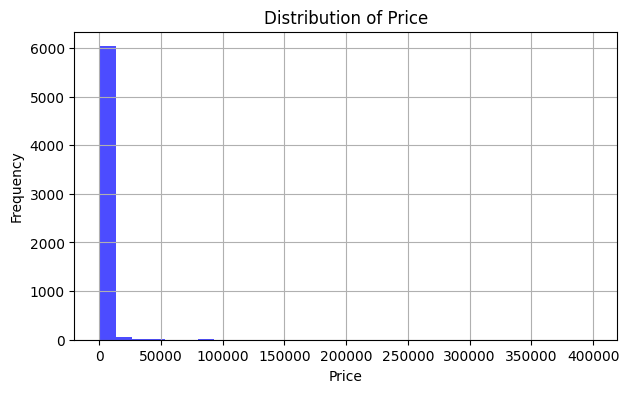

In [120]:
# See Price distribution with histogram
plt.figure(figsize=(7, 4))
plt.hist(merged_df['Price'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

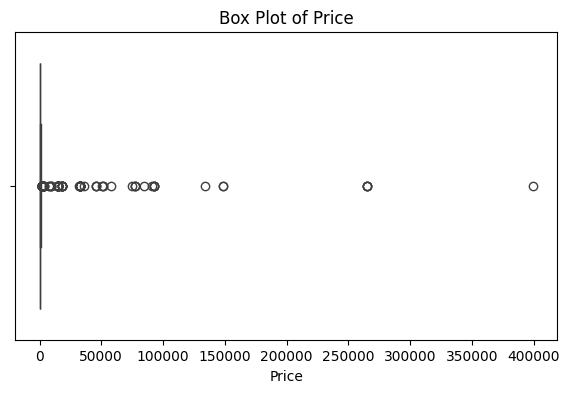

In [121]:
# See Price distribution with boxplot
plt.figure(figsize=(7, 4))
sns.boxplot(x=merged_df['Price'])
plt.title('Box Plot of Price')
plt.xlabel('Price')
plt.show()

In [122]:
# Add a column with price categories. Chosen values were 500, 5000 and 50000
price_bins = [0, 500, 5000, 50000, float('inf')]
price_labels = ['low', 'mid', 'high', 'extra_high']

merged_df['Price Category'] = pd.cut(merged_df['Price'], bins=price_bins, labels=price_labels, include_lowest=True)

In [123]:
# Check NaN values (number and percentage) in the new dataset
for column in merged_df.columns:
    nan_count = merged_df[column].isna().sum()
    total_count = len(merged_df)
    nan_percentage = (nan_count / total_count) * 100

    print(f"Column: '{column}'", f"Number of NaN values: {nan_count}", f"Percentage of NaN values: {nan_percentage:.2f}%")

Column: 'New_Id' Number of NaN values: 0 Percentage of NaN values: 0.00%
Column: 'First Name' Number of NaN values: 3158 Percentage of NaN values: 51.52%
Column: 'Use Case_lead' Number of NaN values: 2394 Percentage of NaN values: 39.05%
Column: 'Source' Number of NaN values: 2331 Percentage of NaN values: 38.03%
Column: 'Status_lead' Number of NaN values: 2329 Percentage of NaN values: 37.99%
Column: 'Discarded/Nurturing Reason' Number of NaN values: 6097 Percentage of NaN values: 99.46%
Column: 'Acquisition Campaign' Number of NaN values: 5087 Percentage of NaN values: 82.99%
Column: 'Created Date_lead' Number of NaN values: 2329 Percentage of NaN values: 37.99%
Column: 'Converted' Number of NaN values: 2329 Percentage of NaN values: 37.99%
Column: 'City' Number of NaN values: 3609 Percentage of NaN values: 58.87%
Column: 'Lead Age' Number of NaN values: 2329 Percentage of NaN values: 37.99%
Column: 'Lead Month' Number of NaN values: 2329 Percentage of NaN values: 37.99%
Column: 'Use

In [124]:
# Drop columns with high percentage of NaN values (Discarded/Nurturing Reason) and the names. columns with less than 50% were kept, but importance will be analyzed
# In case importance is low, they won't be used to avoid bias

cols_to_drop = ["First Name", "Discarded/Nurturing Reason", "Acquisition Campaign", "City"]
merged_df.drop(cols_to_drop, axis=1, inplace= True)

# Resulting columns
merged_df.columns

Index(['New_Id', 'Use Case_lead', 'Source', 'Status_lead', 'Created Date_lead',
       'Converted', 'Lead Age', 'Lead Month', 'Use Case_offer', 'Status_offer',
       'Created Date_offer', 'Close Date', 'Price', 'Discount code', 'Pain',
       'Loss Reason', 'Days Lead Offer', 'Days Offer Close', 'Price Category'],
      dtype='object')

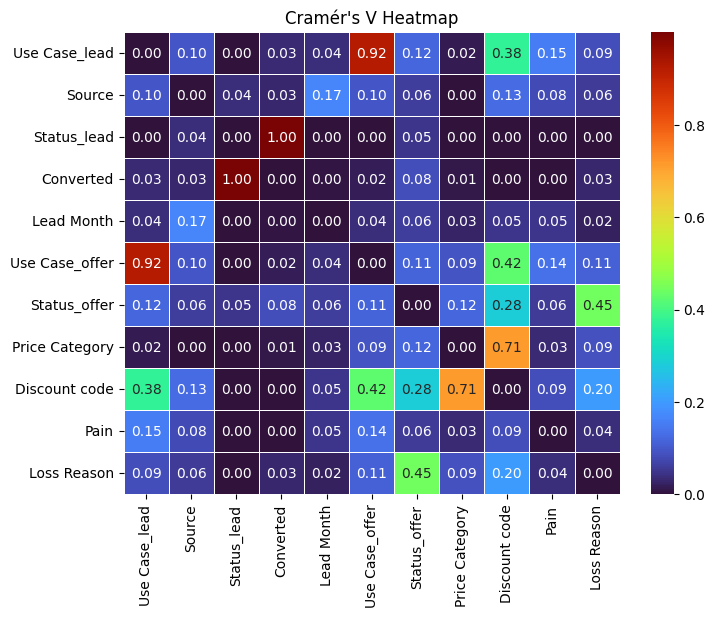

In [125]:
# Calculate Cramér's to check association between the pairs of categorical variables
# This is made for two reasons: see the most associated variables to Status_offer (target) and
# to see possible high associations that could lead to issues of multicollinearity

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Categorical columns
categorical_columns = ['Use Case_lead', 'Source', 'Status_lead', 'Converted',
       'Lead Month', 'Use Case_offer', 'Status_offer','Price Category','Discount code', 'Pain',
       'Loss Reason']

matrix_size = len(categorical_columns)
cramers_matrix = np.zeros((matrix_size, matrix_size))

# Fill the matrix with Cramér's V values
for i, col1 in enumerate(categorical_columns):
    for j, col2 in enumerate(categorical_columns):
        if i != j:
            correlation = cramers_v(merged_df[col1], merged_df[col2])
            cramers_matrix[i, j] = correlation

# Save as dataframe and plot heatmap
cramers_df = pd.DataFrame(cramers_matrix, index=categorical_columns, columns=categorical_columns)

plt.figure(figsize=(8, 6))
sns.heatmap(cramers_df, annot=True, cmap="turbo", fmt=".2f", linewidths=.5)
plt.title("Cramér's V Heatmap")
plt.show()

In [126]:
# Due to high Association and being based on the same info, only one Use_case is going to be used

#Check value counts to see which one has more useful information
value_counts_offer = merged_df['Use Case_offer'].value_counts()
value_counts_lead = merged_df['Use Case_lead'].value_counts()
print("value_counts_offer", value_counts_offer)
print("******")
print("value_counts_lead", value_counts_lead)

#Since the offer has more known values, this column will remain and lead will be dropped

value_counts_offer Use Case_offer
Corporate Events          3487
Educational Seminars      1339
Sports Events             1025
Wedding Planning           240
Concerts and festivals       2
Name: count, dtype: int64
******
value_counts_lead Use Case_lead
Corporate Events          2384
Educational Seminars       749
Sports Events              598
Wedding Planning             4
Concerts and festivals       1
Name: count, dtype: int64


In [127]:
# Drop Use Case_offer 
merged_df = merged_df.drop('Use Case_lead', axis=1)

# Fill NaN for the merged dataset according to the column content

# Replace dictionary with new values
replace_dict_merged = {'Use Case_lead': 'Unknown', 
                       'Use Case_offer': 'Unknown',
                       'Status_lead': 'Unknown',
                       'Source': 'Unknown', 
                       'Pain' : 'Unknown',
                       'Converted': '10000', 
}

# Fill with dict. values
merged_df.fillna(replace_dict_merged, inplace=True)
#merged_df.head()

In [128]:
# Check merged dataset info again
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6130 entries, 0 to 6129
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   New_Id              6130 non-null   object        
 1   Source              6130 non-null   object        
 2   Status_lead         6130 non-null   object        
 3   Created Date_lead   3801 non-null   datetime64[ns]
 4   Converted           6130 non-null   object        
 5   Lead Age            3801 non-null   float64       
 6   Lead Month          3801 non-null   float64       
 7   Use Case_offer      6130 non-null   object        
 8   Status_offer        6130 non-null   object        
 9   Created Date_offer  6130 non-null   datetime64[ns]
 10  Close Date          6130 non-null   datetime64[ns]
 11  Price               6130 non-null   float64       
 12  Discount code       6130 non-null   object        
 13  Pain                6130 non-null   object      

In [129]:
# A new dataset 'merged_df_importance' was created to see importance of features regarding Status_offer as a target variable for classification
merged_df_importance = merged_df[['Source', 'Status_lead', 'Converted', 'Lead Age', 
                                  'Lead Month', 'Use Case_offer', 'Status_offer', 'Price', 'Discount code', 
                                  'Pain', 'Loss Reason', 'Days Lead Offer', 'Days Offer Close', 'Price Category']]

#merged_df_importance.head()

In [130]:
# Feature importance

# RandomForestClassifier

# Convert all columns to string type before encoding
merged_df_importance = merged_df_importance.copy()

for column in merged_df_importance.columns:
    merged_df_importance[column] = merged_df_importance[column].astype(str)

# Label encoding
label_encoders = {}
for column in merged_df_importance.columns:
    if merged_df_importance[column].dtype == 'object':
        label_encoders[column] = LabelEncoder()
        merged_df_importance[column] = label_encoders[column].fit_transform(merged_df_importance[column])

# Splitting the dataset into features (X) and the target variable (y)
X = merged_df_importance.drop('Status_offer', axis=1)
y = merged_df_importance['Status_offer']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Calculate feature importance
feature_importance = rf_model.feature_importances_
feature_names = X.columns

# Combine feature names and importance scores
features_and_importance = zip(feature_names, feature_importance)
sorted_features_and_importance = sorted(features_and_importance, key=lambda x: x[1], reverse=True)

# Sort first 15 features
sorted_features_and_importance[:15]

[('Loss Reason', 0.5775766472219348),
 ('Discount code', 0.11054942399440032),
 ('Days Offer Close', 0.10022632908860774),
 ('Price', 0.05037739403046037),
 ('Lead Age', 0.0389222677729317),
 ('Use Case_offer', 0.02699877316583679),
 ('Pain', 0.026682249385606305),
 ('Days Lead Offer', 0.024714284896882197),
 ('Lead Month', 0.01978535337743098),
 ('Price Category', 0.0124041915859317),
 ('Source', 0.007388309809178328),
 ('Status_lead', 0.0024289468991989084),
 ('Converted', 0.001945828771599959)]

In [131]:
# XGBoost model

X = merged_df_importance.drop('Status_offer', axis=1)
y = merged_df_importance['Status_offer']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.7, random_state=42)

# Instantiate the XGBoost model
xgb_model = XGBClassifier(random_state=42)

# Train the XGBoost model on the subset
xgb_model.fit(X_train, y_train)

# Feature importance from the XGBoost model trained on the subset
xgb_feature_importance = xgb_model.feature_importances_
xgb_feature_importance = zip(feature_names, xgb_feature_importance)
sorted_xgb_features_and_importance = sorted(xgb_feature_importance, key=lambda x: x[1], reverse=True)

# Sort first 15 features
sorted_xgb_features_and_importance[:15]

[('Loss Reason', 0.83487934),
 ('Price Category', 0.027447296),
 ('Use Case_offer', 0.025169844),
 ('Days Offer Close', 0.016797367),
 ('Discount code', 0.016646678),
 ('Lead Age', 0.015421103),
 ('Days Lead Offer', 0.01270964),
 ('Price', 0.012483233),
 ('Lead Month', 0.011035089),
 ('Source', 0.010425767),
 ('Pain', 0.009936865),
 ('Status_lead', 0.007047811),
 ('Converted', 0.0)]

In [132]:
# Print top 15 features side by side to identify and select features by importance after Random Forest and XGBoost
print("{:<25} {:<20} {:<25} {:<20}".format("Feature", "Importance (XGBoost)", "Features", "Importance (Random Forest)"))
print("="*93)

for subset_feature, all_feature in zip(sorted_xgb_features_and_importance[:15], sorted_features_and_importance[:15]):
    print("{:<25} {:<20} {:<25} {:<20}".format(subset_feature[0], subset_feature[1], all_feature[0], all_feature[1]))

Feature                   Importance (XGBoost) Features                  Importance (Random Forest)
Loss Reason               0.8348793387413025   Loss Reason               0.5775766472219348  
Price Category            0.027447296306490898 Discount code             0.11054942399440032 
Use Case_offer            0.025169843807816505 Days Offer Close          0.10022632908860774 
Days Offer Close          0.016797367483377457 Price                     0.05037739403046037 
Discount code             0.016646677628159523 Lead Age                  0.0389222677729317  
Lead Age                  0.01542110275477171  Use Case_offer            0.02699877316583679 
Days Lead Offer           0.012709639966487885 Pain                      0.026682249385606305
Price                     0.012483232654631138 Days Lead Offer           0.024714284896882197
Lead Month                0.011035089381039143 Lead Month                0.01978535337743098 
Source                    0.010425766929984093 Price C

In [133]:
# Is Lead Age worth keeping?

status_offer_dummies = pd.get_dummies(merged_df_importance['Status_offer'])

# Merging the dummy variables with 'Lead Age'
lead_age_status_offer_df = pd.concat([merged_df_importance['Lead Age'], status_offer_dummies], axis=1)

# Calculate the correlation between 'Lead Age' and each 'Status_offer' possible value
correlation_matrix = lead_age_status_offer_df.corr()

# Extracting the correlations with 'Lead Age'
lead_age_correlations = correlation_matrix['Lead Age'].drop('Lead Age')  # Drop the correlation of Lead Age with itself
lead_age_correlations

# Since there are missing values in this column and correlation is not very significant, I decided to leave this column out

0   -0.010170
1    0.005215
2    0.033509
3   -0.042693
4    0.019243
5   -0.073615
Name: Lead Age, dtype: float64

In [134]:
# Build final dataset
columns = ['Loss Reason', 'Days Offer Close', 'Discount code', 'Price', 'Use Case_offer', 'Price Category', 'Days Lead Offer', 'Pain','Source', 'Status_offer']

final_dataset = merged_df[columns]
final_dataset.head()

,Loss Reason,Days Offer Close,Discount code,Price,Use Case_offer,Price Category,Days Lead Offer,Pain,Source,Status_offer
0,No Loss,0,SAVEMORE50,300.0,Educational Seminars,low,-1.0,operations,Unknown,Closed Won
1,price,1,No Discount,150.0,Sports Events,low,-1.0,operations,Unknown,Closed Lost
2,no response,1,HALFYEAR20G,768.0,Sports Events,mid,-1.0,operations,Unknown,Closed Lost
3,No Loss,0,DISCOUNT50POWER,240.0,Corporate Events,low,0.0,financial control,Inbound,Closed Won
4,no response,8,SAVEMONTH50G,240.0,Sports Events,low,-1.0,financial control,Unknown,Closed Lost


In [135]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6130 entries, 0 to 6129
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Loss Reason       6130 non-null   object  
 1   Days Offer Close  6130 non-null   int64   
 2   Discount code     6130 non-null   object  
 3   Price             6130 non-null   float64 
 4   Use Case_offer    6130 non-null   object  
 5   Price Category    6130 non-null   category
 6   Days Lead Offer   6130 non-null   float64 
 7   Pain              6130 non-null   object  
 8   Source            6130 non-null   object  
 9   Status_offer      6130 non-null   object  
dtypes: category(1), float64(2), int64(1), object(6)
memory usage: 437.3+ KB


In [136]:
# Save enriched dataset to csv file
final_dataset.to_csv('./Data/enriched_dataset.csv', index=False, header = True)

In [137]:
df = pd.read_csv("./Data/enriched_dataset.csv", delimiter=",", low_memory=False, index_col=None, parse_dates=True)
df.head()

,Loss Reason,Days Offer Close,Discount code,Price,Use Case_offer,Price Category,Days Lead Offer,Pain,Source,Status_offer
0,No Loss,0,SAVEMORE50,300.0,Educational Seminars,low,-1.0,operations,Unknown,Closed Won
1,price,1,No Discount,150.0,Sports Events,low,-1.0,operations,Unknown,Closed Lost
2,no response,1,HALFYEAR20G,768.0,Sports Events,mid,-1.0,operations,Unknown,Closed Lost
3,No Loss,0,DISCOUNT50POWER,240.0,Corporate Events,low,0.0,financial control,Inbound,Closed Won
4,no response,8,SAVEMONTH50G,240.0,Sports Events,low,-1.0,financial control,Unknown,Closed Lost
